# Optional Lab: Multiple Variable Linear Regression

In this lab, you will extend the data structures and previously developed routines to support multiple features. Several routines are updated making the lab appear lengthy, but it makes minor adjustments to previous routines making it quick to review.
# Outline
- [&nbsp;&nbsp;1.1 Goals](#toc_15456_1.1)
- [&nbsp;&nbsp;1.2 Tools](#toc_15456_1.2)
- [&nbsp;&nbsp;1.3 Notation](#toc_15456_1.3)
- [2 Problem Statement](#toc_15456_2)
- [&nbsp;&nbsp;2.1 Matrix X containing our examples](#toc_15456_2.1)
- [&nbsp;&nbsp;2.2 Parameter vector w, b](#toc_15456_2.2)
- [3 Model Prediction With Multiple Variables](#toc_15456_3)
- [&nbsp;&nbsp;3.1 Single Prediction element by element](#toc_15456_3.1)
- [&nbsp;&nbsp;3.2 Single Prediction, vector](#toc_15456_3.2)
- [4 Compute Cost With Multiple Variables](#toc_15456_4)
- [5 Gradient Descent With Multiple Variables](#toc_15456_5)
- [&nbsp;&nbsp;5.1 Compute Gradient with Multiple Variables](#toc_15456_5.1)
- [&nbsp;&nbsp;5.2 Gradient Descent With Multiple Variables](#toc_15456_5.2)
- [6 Congratulations](#toc_15456_6)


<a name="toc_15456_1.1"></a>
## 1.1 Goals
- Extend our regression model  routines to support multiple features
    - Extend data structures to support multiple features
    - Rewrite prediction, cost and gradient routines to support multiple features
    - Utilize NumPy `np.dot` to vectorize their implementations for speed and simplicity

<a name="toc_15456_1.2"></a>
## 1.2 Tools
In this lab, we will make use of: 
- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data

In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('deeplearning.mplstyle')
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

<a name="toc_15456_1.3"></a>
## 1.3 Notation
Here is a summary of some of the notation you will encounter, updated for multiple features.  

|General <img width=70/> <br />  Notation  <img width=70/> | Description<img width=350/>| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example maxtrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train` 
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at $\mathbf{x^{(i)}}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` | 


<a name="toc_15456_2"></a>
# 2 Problem Statement

You will use the motivating example of housing price prediction. The training dataset contains three examples with four features (size, bedrooms, floors and, age) shown in the table below.  Note that, unlike the earlier labs, size is in sqft rather than 1000 sqft. This causes an issue, which you will solve in the next lab!

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

You will build a linear regression model using these values so you can then predict the price for other houses. For example, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  

Please run the following code cell to create your `X_train` and `y_train` variables.

In [2]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

<a name="toc_15456_2.1"></a>
## 2.1 Matrix X containing our examples
Similar to the table above, examples are stored in a NumPy matrix `X_train`. Each row of the matrix represents one example. When you have $m$ training examples ( $m$ is three in our example), and there are $n$ features (four in our example), $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).


$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  

Display the input data.

In [3]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y Shape: (3,), y Type:<class 'numpy.ndarray'>)
[460 232 178]


<a name="toc_15456_2.2"></a>
## 2.2 Parameter vector w, b

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

For demonstration, $\mathbf{w}$ and $b$ will be loaded with some initial selected values that are near the optimal. $\mathbf{w}$ is a 1-D NumPy vector.

In [4]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


<a name="toc_15456_3"></a>
# 3 Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

To demonstrate the dot product, we will implement prediction using (1) and (2).

<a name="toc_15456_3.1"></a>
## 3.1 Single Prediction element by element
Our previous prediction multiplied one feature value by one parameter and added a bias parameter. A direct extension of our previous implementation of prediction to multiple features would be to implement (1) above using loop over each element, performing the multiply with its parameter and then adding the bias parameter at the end.


In [5]:
def predict_single_loop(x, w, b): 
    """
    single predict using linear regression
    
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters    
      b (scalar):  model parameter     
      
    Returns:
      p (scalar):  prediction
    """
    n = x.shape[0]
    p = 0
    for i in range(n):
        p_i = x[i] * w[i]  
        p = p + p_i         
    p = p + b                
    return p

In [6]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.9999976194083


Note the shape of `x_vec`. It is a 1-D NumPy vector with 4 elements, (4,). The result, `f_wb` is a scalar.

<a name="toc_15456_3.2"></a>
## 3.2 Single Prediction, vector

Noting that equation (1) above can be implemented using the dot product as in (2) above. We can make use of vector operations to speed up predictions.

Recall from the Python/Numpy lab that NumPy `np.dot()`[[link](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)] can be used to perform a vector dot product. 

In [7]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b     
    return p    

In [8]:
# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.99999761940825


The results and shapes are the same as the previous version which used looping. Going forward, `np.dot` will be used for these operations. The prediction is now a single statement. Most routines will implement it directly rather than calling a separate predict routine.

<a name="toc_15456_4"></a>
# 4 Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

Below is an implementation of equations (3) and (4). Note that this uses a *standard pattern for this course* where a for loop over all `m` examples is used.

In [9]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [10]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 1.5578904880036537e-12


**Expected Result**: Cost at optimal w : 1.5578904045996674e-12

<a name="toc_15456_5"></a>
# 5 Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


<a name="toc_15456_5.1"></a>
## 5.1 Compute Gradient with Multiple Variables
An implementation for calculating the equations (6) and (7) is below. There are many ways to implement this. In this version, there is an
- outer loop over all m examples. 
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ for the example can be computed directly and accumulated
    - in a second loop over all n features:
        - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ is computed for each $w_j$.
   

In [11]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [12]:
#Compute and display gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -1.673925169143331e-06
dj_dw at initial w,b: 
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


**Expected Result**:   
dj_db at initial w,b: -1.6739251122999121e-06  
dj_dw at initial w,b:   
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]  

<a name="toc_15456_5.2"></a>
## 5.2 Gradient Descent With Multiple Variables
The routine below implements equation (5) above.

In [13]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In the next cell you will test the implementation. 

In [14]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost  2529.46   
Iteration  100: Cost   695.99   
Iteration  200: Cost   694.92   
Iteration  300: Cost   693.86   
Iteration  400: Cost   692.81   
Iteration  500: Cost   691.77   
Iteration  600: Cost   690.73   
Iteration  700: Cost   689.71   
Iteration  800: Cost   688.70   
Iteration  900: Cost   687.69   
b,w found by gradient descent: -0.00,[ 0.2   0.   -0.01 -0.07] 
prediction: 426.19, target value: 460
prediction: 286.17, target value: 232
prediction: 171.47, target value: 178


**Expected Result**:    
b,w found by gradient descent: -0.00,[ 0.2   0.   -0.01 -0.07]   
prediction: 426.19, target value: 460  
prediction: 286.17, target value: 232  
prediction: 171.47, target value: 178  

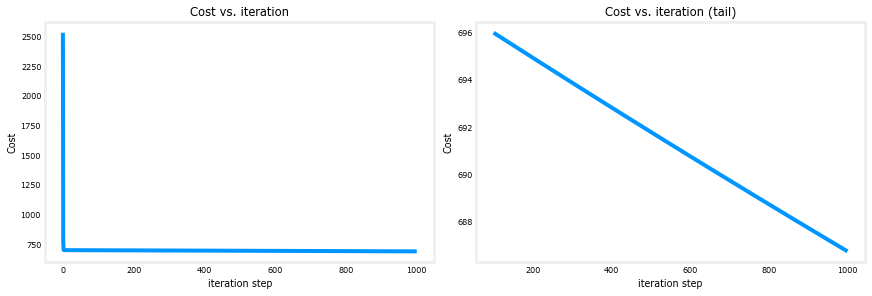

In [15]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

*These results are not inspiring*! Cost is still declining and our predictions are not very accurate. The next lab will explore how to improve on this.


<a name="toc_15456_6"></a>
# 6 Congratulations!
In this lab you:
- Redeveloped the routines for linear regression, now with multiple variables.
- Utilized NumPy `np.dot` to vectorize the implementations